# Connecting to Eikon Data API

In [22]:
import refinitiv.data as rd
import refinitiv.data.eikon as ek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%pip install nbformat
import os
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor

import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


In [2]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x12764ed50 {name='workspace'}>

In [23]:
# Check if the portfolio.csv file is created and data is saved in the directory or not 
if 'portfolio.csv' in os.listdir():
    print('portfolio data exists in the directory')
else:
    # Run the data.ipynb notebook to create the portfolio.csv file
    notebook_filename = 'data.ipynb'

    with open(notebook_filename) as f:
        nb = nbformat.read(f, as_version=4)
        # Increase the timeout to a value greater than 10 minutes (e.g., 1200 seconds for 20 minutes)
        ep = ExecutePreprocessor(timeout=1200, kernel_name='python3')

        try:
            ep.preprocess(nb, {'metadata': {'path': './'}})
            print(f'{notebook_filename} executed successfully')
        except Exception as e:
            print(f'Error executing {notebook_filename}: {e}')

        # Save the executed notebook (optional)
        with open(notebook_filename, 'w', encoding='utf-8') as f:
            nbformat.write(nb, f)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


data.ipynb executed successfully


In [24]:
portfolio_df = pd.read_csv('portfolio.csv', index_col=0)

 Most investors aren't okay with taking on high-levels of risk, so our goal is to find the best ratio of risk vs returns. Ideally, we are taking the most risk we are comfortable with and attempting to maximize those returns. That naturally leads to an important question, "How do we measure risk?". Well, this can lead you down a rabbit hole because there are many ways to measure risk and some are more appropriate than others depending on the situation at hand. In our case, we will use a very popular metric, the `Sharpe Ratio`. The Sharpe Ratio, is used is a measure for calculating risk-adjusted return and has been the industry standard for such calculations. The Sharpe Ratio allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

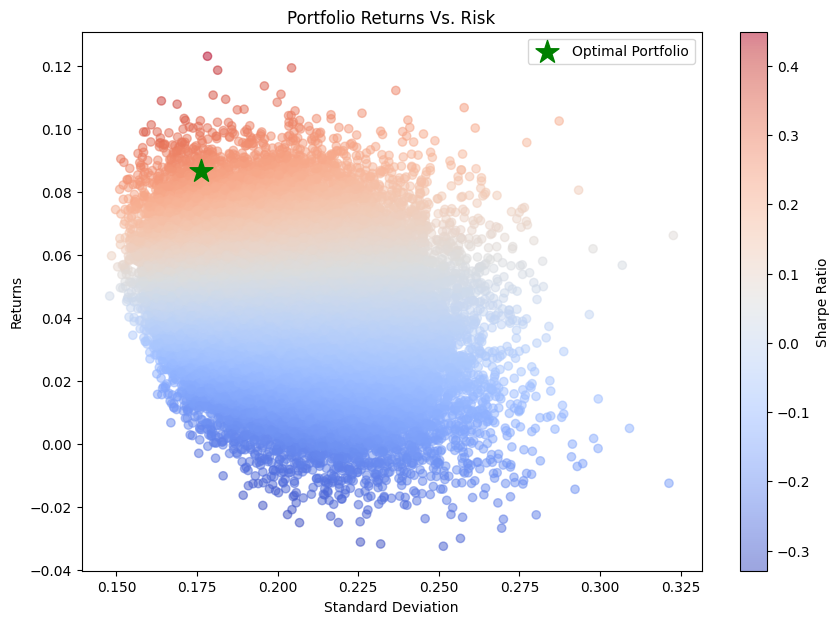

,Returns,Volatility,Sharpe Ratio,ESG Score,WEIR.L,DCC.L,SVT.L,RKT.L,BATS.L,RS1R.L,IMB.L,BP.L,ANTO.L,NXT.L
0,0.086685,0.176151,0.248001,80.123049,0.055455,0.043479,0.027745,0.254143,0.147945,0.005922,0.099053,0.074799,0.184531,0.106928


In [25]:
# Calculate the Log of returns
log_return = np.log(1 + portfolio_df.pct_change())

# Monte Carlo Simulation parameters
num_of_portfolios = 50000
risk_free_rate = 0.043
num_of_constituents = 10  # Number of constituents in each random portfolio

# Prepare arrays to store the simulation results
ret_arr = np.zeros(num_of_portfolios)
vol_arr = np.zeros(num_of_portfolios)
sharpe_arr = np.zeros(num_of_portfolios)
esg_arr = np.zeros(num_of_portfolios)
all_weights = []
all_symbols = []

# Convert ESG scores to a dictionary for easy lookup
esg_scores_dict = top_per_sector.set_index('Instrument')['ESG Score'].to_dict()

# Start the simulations
for ind in range(num_of_portfolios):
    # Randomly select 10 symbols
    selected_symbols = np.random.choice(portfolio_df.columns, num_of_constituents, replace=False)
    
    # Extract data for the selected symbols
    selected_log_return = log_return[selected_symbols]
    
    # Generate random portfolio weights
    weights = np.random.random(num_of_constituents)
    weights /= np.sum(weights)
    
    # Store the weights and symbols
    all_weights.append(weights)
    all_symbols.append(selected_symbols)
    
    # Calculate expected returns and add to returns array
    ret_arr[ind] = np.sum((selected_log_return.mean() * weights) * 252)
    
    # Calculate volatility and add to volatility array
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(selected_log_return.cov() * 252, weights)))
    
    # Calculate Sharpe ratio and add to Sharpe ratio array
    sharpe_arr[ind] = (ret_arr[ind] - risk_free_rate) / vol_arr[ind]
    
    # Extract ESG scores for the selected symbols
    esg_scores = np.array([esg_scores_dict[symbol] for symbol in selected_symbols])
    
    # Calculate ESG score and add to ESG array
    esg_arr[ind] = np.sum(esg_scores * weights)

# Create a DataFrame for the simulation results
simulations_df = pd.DataFrame({
    'Returns': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr,
    'ESG Score': esg_arr,
    'Symbols': all_symbols,
    'Weights': all_weights
})

# Define weights for the composite score
sharpe_weight = 0.5
esg_weight = 0.5

# Normalize Sharpe ratios and ESG scores
simulations_df['Normalized Sharpe'] = (simulations_df['Sharpe Ratio'] - simulations_df['Sharpe Ratio'].min()) / (simulations_df['Sharpe Ratio'].max() - simulations_df['Sharpe Ratio'].min())
simulations_df['Normalized ESG'] = (simulations_df['ESG Score'] - simulations_df['ESG Score'].min()) / (simulations_df['ESG Score'].max() - simulations_df['ESG Score'].min())

# Calculate the composite score
simulations_df['Composite Score'] = sharpe_weight * simulations_df['Normalized Sharpe'] + esg_weight * simulations_df['Normalized ESG']

# Find the portfolio with the highest composite score
optimal_portfolio = simulations_df.loc[simulations_df['Composite Score'].idxmax()]

# Extract the symbols and weights for the optimal portfolio
optimal_symbols = optimal_portfolio['Symbols']
optimal_weights = optimal_portfolio['Weights']

# Create a dictionary for the optimal portfolio data
optimal_portfolio_data = {
    'Returns': optimal_portfolio['Returns'],
    'Volatility': optimal_portfolio['Volatility'],
    'Sharpe Ratio': optimal_portfolio['Sharpe Ratio'],
    'ESG Score': optimal_portfolio['ESG Score']
}
optimal_portfolio_data.update({optimal_symbols[i]: optimal_weights[i] for i in range(num_of_constituents)})

# Convert the dictionary to a DataFrame
optimal_portfolio_df = pd.DataFrame([optimal_portfolio_data])

# Plotting the Monte Carlo simulation results
plt.figure(figsize=(10, 7))
plt.scatter(simulations_df['Volatility'], simulations_df['Returns'], c=simulations_df['Sharpe Ratio'], cmap='coolwarm', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_portfolio['Volatility'], optimal_portfolio['Returns'], marker='*', color='g', s=300, label='Optimal Portfolio')
plt.title('Portfolio Returns Vs. Risk')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Print the optimal portfolio
optimal_portfolio_df


# Optimization

Alright, now remember that up above I mentioned that we would be exploring multiple ways to optimize our portfolio. The first was using Monte Carlo Simulation that would try thousands of random values and find the best values. The draw back to using the Monte Carlo Simulation is that it's not the most efficent way to find the optimial values. Instead we can use mathematical techniques to easily arrive at the optimial values.

To help run this new optimization method, we will need to define a few more functions that we will use in our method. The first function is the `get_metrics()` function which will return the metrics for a given set of weights provided. In other words, think of it as a "lookup function" where we can return the results of a certain weight. The second function is the `neg_sharpe` function which is used as a minimization function. The minimization function is used to help find the values which results in the lowest sharpe ratio. In Scipy’s optimize function, there’s no `maximize`, so as an objective function you need to pass something that should be minimized.

The third function is `check_sum` function which is used as a constraint. What is will do is make sure that the weights that are passed through meet the constraint that we must have a portfolio allocation equal 100%, not more and not less.

In [26]:
# Define the optimization function
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(mean_returns * weights) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (returns - risk_free_rate) / volatility
    return -sharpe_ratio

def check_sum(weights):
    return np.sum(weights) - 1

# Function to perform optimization on given portfolios
def optimize_portfolio(initial_weights, mean_returns, cov_matrix, esg_scores, risk_free_rate):
    bounds = tuple((0, 1) for _ in range(len(initial_weights)))
    constraints = (
        {'type': 'eq', 'fun': check_sum},
        {'type': 'ineq', 'fun': lambda weights: np.sum(weights * esg_scores) - esg_threshold}
    )
    result = minimize(
        negative_sharpe_ratio,
        initial_weights,
        args=(mean_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result

# Assuming mean_returns, cov_matrix, and esg_scores_dict are defined
# Define risk-free rate and ESG threshold
risk_free_rate = 0.043  # Example risk-free rate
esg_threshold = 80  # Example threshold for minimum ESG score

optimized_results = []

for idx, row in optimal_portfolio_df.iterrows():
    # Extract symbols and weights from the row
    selected_symbols = row.index[4:]  # Symbols start from the 5th column onward
    initial_weights = row[selected_symbols].values
    esg_scores = np.array([esg_scores_dict[symbol] for symbol in selected_symbols])

    # Assume mean_returns and cov_matrix are previously calculated for these symbols
    selected_log_return = log_return[selected_symbols]
    
    result = optimize_portfolio(initial_weights, selected_log_return.mean(), selected_log_return.cov(), esg_scores, risk_free_rate)

    optimized_weights = result.x
    optimized_return = np.sum(selected_log_return.mean() * optimized_weights) * 252
    optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(selected_log_return.cov() * 252, optimized_weights)))
    optimized_sharpe = (optimized_return - risk_free_rate) / optimized_volatility
    optimized_esg = np.sum(optimized_weights * esg_scores)
    
    # Ensure weights sum to one
    weight_sum = np.sum(optimized_weights)
    assert np.isclose(weight_sum, 1), f"Weights do not sum to 1, sum = {weight_sum}"

    optimized_results.append({
        'Returns': optimized_return,
        'Volatility': optimized_volatility,
        'Sharpe Ratio': optimized_sharpe,
        'ESG Score': optimized_esg,
        **{symbol: weight for symbol, weight in zip(selected_symbols, optimized_weights)}
    })

# Convert the optimized results to a DataFrame
optimized_df = pd.DataFrame(optimized_results)

# Display the optimized portfolio metrics
optimized_df


,Returns,Volatility,Sharpe Ratio,ESG Score,WEIR.L,DCC.L,SVT.L,RKT.L,BATS.L,RS1R.L,IMB.L,BP.L,ANTO.L,NXT.L
0,0.102521,0.190622,0.312247,80.0,0.0,0.021785,0.0,0.291811,0.197041,6.933942e-17,0.0,1.866016e-16,0.215417,0.273947


In [27]:
# Extract the asset names and their weights
assets = optimized_df.columns[4:]
weights = optimized_df.iloc[0, 4:].values

# Filter out assets with zero weights
non_zero_weights = [(asset, weight) for asset, weight in zip(assets, weights) if weight > 0]
non_zero_assets, non_zero_weights = zip(*non_zero_weights)

# Create a pie chart for the asset weights
fig_pie = go.Figure()

fig_pie.add_trace(go.Pie(
    labels=non_zero_assets,
    values=non_zero_weights,
    textinfo='label+percent',
    hoverinfo='label+percent+value'
))

fig_pie.update_layout(
    title='Optimized Portfolio Asset Weights',
    template='plotly_white'
)

# Extract portfolio metrics
metrics = {
    'Returns': optimized_df['Returns'].values[0],
    'Volatility': optimized_df['Volatility'].values[0],
    'Sharpe Ratio': optimized_df['Sharpe Ratio'].values[0],
    'ESG Score': optimized_df['ESG Score'].values[0]
}

# Create a table for the portfolio metrics
fig_table = go.Figure(data=[go.Table(
    header=dict(values=['Metric', 'Value'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[list(metrics.keys()), list(metrics.values())],
               fill_color=[['paleturquoise'], 
                           [['rgba(255, 0, 0, 0.6)' if k == 'Returns' else 'rgba(0, 255, 0, 0.6)' for k in metrics.keys()]],
                           [['rgba(255, 0, 0, 0.3)' if k == 'Volatility' else 'rgba(0, 255, 0, 0.3)' for k in metrics.keys()]],
                           [['rgba(255, 0, 0, 0.3)' if k == 'Sharpe Ratio' else 'rgba(0, 255, 0, 0.3)' for k in metrics.keys()]],
                           [['rgba(0, 255, 0, 0.3)' for _ in metrics.keys()]]],
               align='left'))
])

fig_table.update_layout(
    title='Optimized Portfolio Metrics',
    template='plotly_white'
)

# Show the plots
fig_pie.show()
fig_table.show()